In [1]:
# PyTooch関連ライブラリインポート

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
# それ以外のライブラリインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# 分類クラス数
num_classes = 10

# 学習繰り返し回数
nb_epoch = 20

# 1回の学習で何枚の画像を使うか
batch_size = 128

In [4]:
# 学習データ読み込み

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


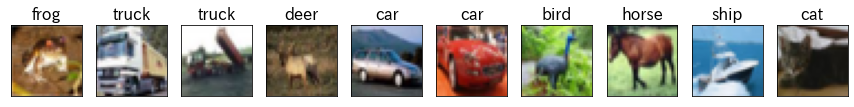

In [5]:
# 最初の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    image, label = trainset[i]
    np_image = image.numpy().copy()
    img = np.transpose(np_image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(classes[label], fontsize=16)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
# モデルクラスの定義

class cifar10_cnn(nn.Module):
  def __init__(self, num_classes):
    super(cifar10_cnn,self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1), padding_mode='replicate')
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1), padding_mode='replicate')
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.relu = nn.ReLU(inplace=True)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.maxpool = nn.MaxPool2d((2,2))
    self.classifier1 = nn.Linear(2304, 512)
    self.classifier2 = nn.Linear(512, num_classes)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool,
        self.dropout1,
        self.conv3,
        self.relu,
        self.conv4,
        self.relu,
        self.dropout1,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.classifier1,
       self.relu,
       self.dropout2,
       self.classifier2)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x    

In [7]:
# GPUの確認

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
# モデルインスタンスの生成とGPUの割り当て

net = cifar10_cnn(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net

cifar10_cnn(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (classifier1): Linear(in_features=2304, out_features=512, bias=True)
  (classifier2): Linear(in_features=512, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dila

In [10]:
# モデルのサマリー表示

from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]             896
              ReLU-3           [-1, 32, 32, 32]               0
              ReLU-4           [-1, 32, 32, 32]               0
              ReLU-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 30, 30]           9,248
            Conv2d-7           [-1, 32, 30, 30]           9,248
              ReLU-8           [-1, 32, 30, 30]               0
              ReLU-9           [-1, 32, 30, 30]               0
             ReLU-10           [-1, 32, 30, 30]               0
        MaxPool2d-11           [-1, 32, 15, 15]               0
        MaxPool2d-12           [-1, 32, 15, 15]               0
          Dropout-13           [-1, 32, 15, 15]               0
          Dropout-14           [-1, 32,

In [11]:
# 学習

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(nb_epoch):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    #train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      #view()での変換をしない
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
    #val
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        #view()での変換をしない
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], loss: {loss:.4f} val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, nb_epoch, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/20], loss: 0.0124 val_loss: 0.0099, val_acc: 0.5523
Epoch [2/20], loss: 0.0094 val_loss: 0.0085, val_acc: 0.6303
Epoch [3/20], loss: 0.0081 val_loss: 0.0075, val_acc: 0.6753
Epoch [4/20], loss: 0.0072 val_loss: 0.0070, val_acc: 0.6948
Epoch [5/20], loss: 0.0065 val_loss: 0.0062, val_acc: 0.7323
Epoch [6/20], loss: 0.0060 val_loss: 0.0059, val_acc: 0.7463
Epoch [7/20], loss: 0.0056 val_loss: 0.0056, val_acc: 0.7546
Epoch [8/20], loss: 0.0053 val_loss: 0.0054, val_acc: 0.7668
Epoch [9/20], loss: 0.0050 val_loss: 0.0054, val_acc: 0.7718
Epoch [10/20], loss: 0.0048 val_loss: 0.0054, val_acc: 0.7672
Epoch [11/20], loss: 0.0046 val_loss: 0.0053, val_acc: 0.7733
Epoch [12/20], loss: 0.0044 val_loss: 0.0051, val_acc: 0.7820
Epoch [13/20], loss: 0.0042 val_loss: 0.0051, val_acc: 0.7818
Epoch [14/20], loss: 0.0040 val_loss: 0.0051, val_acc: 0.7834
Epoch [15/20], loss: 0.0039 val_loss: 0.0050, val_acc: 0.7872
Epoch [16/20], loss: 0.0037 val_loss: 0.0051, val_acc: 0.7859
Epoch [17/20], lo

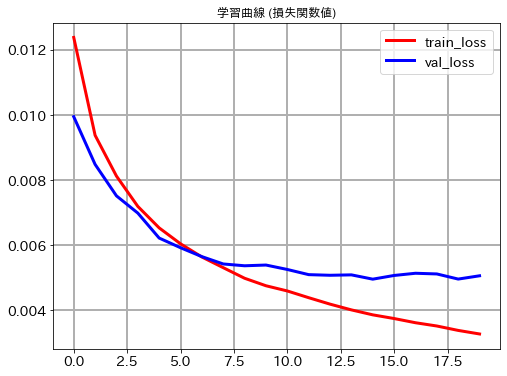

In [12]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
plt.plot(train_loss_list,label='train_loss', lw=3, c='r')
plt.plot(val_loss_list,label='val_loss', lw=3, c='b')
plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

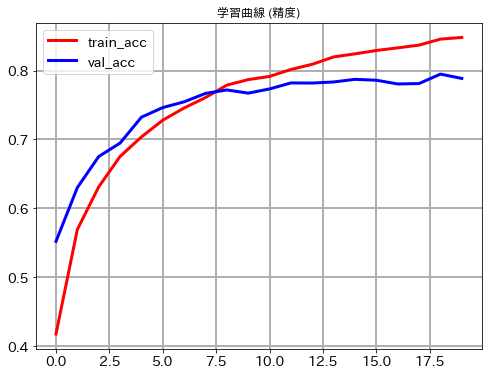

In [13]:
# 学習曲線 (精度)
plt.figure(figsize=(8,6))
plt.plot(train_acc_list,label='train_acc', lw=3, c='r')
plt.plot(val_acc_list,label='val_acc', lw=3, c='b')
plt.title('学習曲線 (精度)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()